# Volume 3: Gibbs Sampling and LDA

Caelan Osman

Math 405

January 28, 2022

In [1]:
import numpy as np
from scipy.special import gammaln
from scipy.stats import invgamma
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

## Problem 1

Implement a Gibbs sampler for the exam scores problem (using the data in `examscores.npy`).
Test your sampler with priors $\nu=80$, $\tau^{2} = 16$, $\alpha = 3$, and $\beta = 50$, collecting $1000$ samples.
Plot your samples of $\mu$ and your samples of $\sigma^{2}$.

In [2]:
def gibbs(y, nu, tau2, alpha, beta, n_samples = int(1e3)):
    """Gibbs sampler for the exam scores problem, assuming the
    following likelihood and priors.
        y_i    ~ N(mu, sigma2),
        mu     ~ N(nu, tau2),
        sigma2 ~ IG(alpha, beta),

    Parameters:
        y ((N,) ndarray): the exam scores.
        nu (float): The prior mean parameter for mu.
        tau2 (float > 0): The prior variance parameter for mu.
        alpha (float > 0): The prior alpha parameter for sigma2.
        beta (float < 0): The prior beta parameter for sigma2.
        n_samples (int): the number of samples to draw.

    Returns:
        ((n_samples, 2) ndarray): The mu and sigma2 samples (as columns).
    """
    #initialize sampling variables
    N = y.shape[0]
    mu = np.mean(y)
    y_sum = np.sum(y)
    
    #get unbiased sample variance
    sigma2 = 1/(y.size-1) * np.sum((y-mu)**2)
    #intialize alphaprime
    alphaprime = alpha + N/2

    #now we sample
    samples = np.empty((n_samples, 2))
    for k in range(0, n_samples):
        #initial sample if we are initializing
        if k == 0:
            samples[0] = [mu, sigma2]
            continue
        
        #make choice of what to sample
        choice = np.random.randint(low=0, high=2)
        #choice = np.random.uniform(low=0, high=1)
        if choice==1:
            #create new variables using previous draw
            sigma2prime = (1/tau2 + N/samples[k-1, 1])**(-1)
            muprime = sigma2prime*(nu/tau2 + y_sum/samples[k-1, 1])
            #draw
            mu_draw = norm.rvs(muprime, scale=np.sqrt(sigma2prime))
            #set samples
            samples[k, 0] = mu_draw
            samples[k, 1] = samples[k-1, 1]
        elif choice==0:
            #create new variable using previous draw
            betaprime = beta + np.sum((y - samples[k-1, 0])**2)/2
            #draw
            sigma2_draw = invgamma.rvs(alphaprime, scale=betaprime)
            #set samples
            samples[k, 0] = samples[k-1, 0]
            samples[k, 1] = sigma2_draw

    return samples



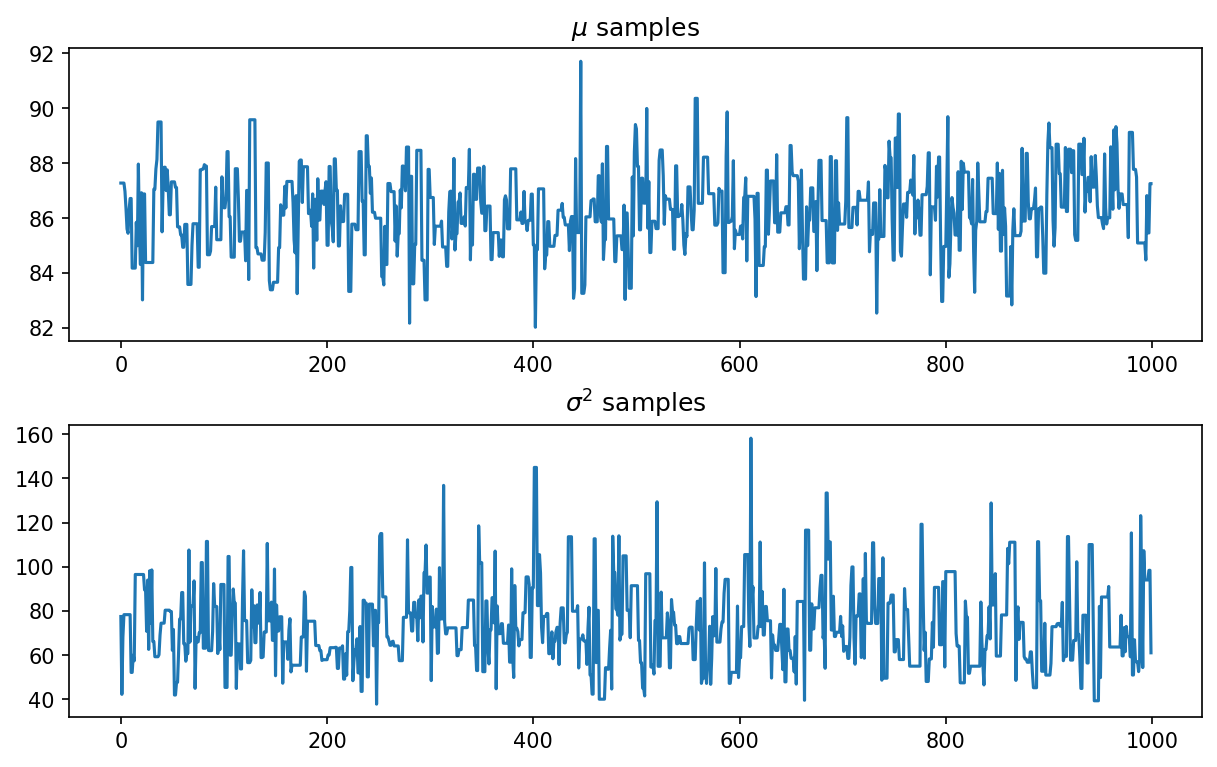

In [3]:
def problem1():

    #initalize variables
    y = np.load('examscores.npy')
    nu = 80
    tau2 = 16
    alpha = 3
    beta = 50
    #draw samples
    samples = gibbs(y, nu, tau2, alpha, beta)
    #plot the samples
    fig, axs = plt.subplots(2,1 , constrained_layout=True, figsize=(8, 5))
    fig.set_dpi(150)
    ax = axs[0]
    ax.plot(samples[:, 0])
    ax.set_title(r'$\mu$ samples')
    ax = axs[1]
    ax.plot(samples[:, 1])
    ax.set_title(r'$\sigma^2$ samples')
    plt.show()

    return
problem1()

## Problem 2

Plot the kernel density estimators for the posterior distributions of $\mu$ and $\sigma^2$.

Next, use your samples of $\mu$ and $\sigma^2$ to draw samples from the posterior predictive distribution.
Plot the kernel density estimator of your sampled scores.

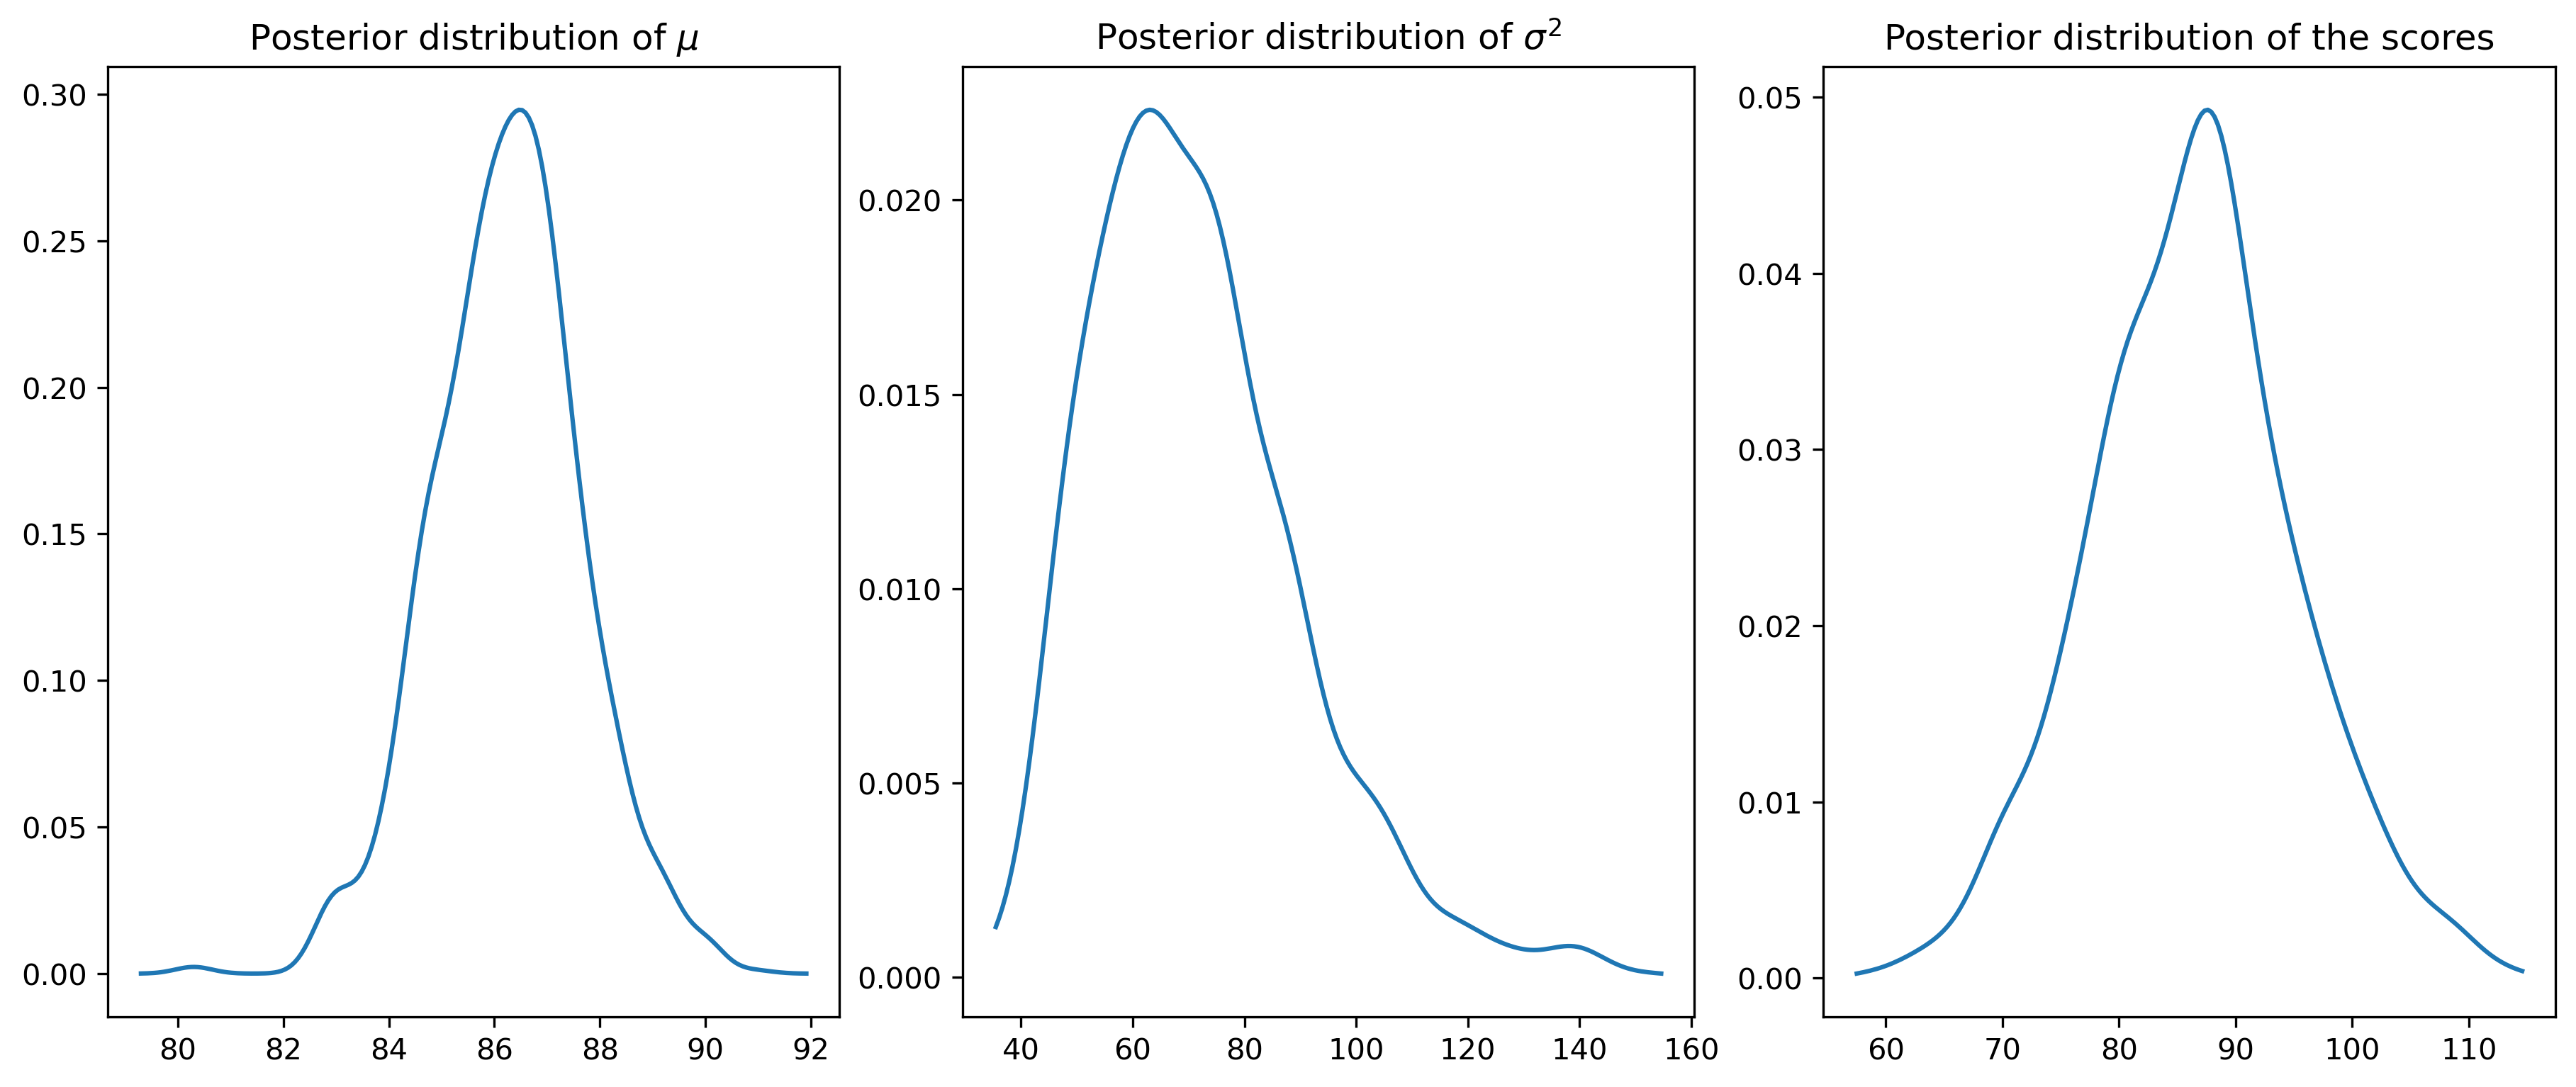

<Figure size 1200x800 with 0 Axes>

In [5]:
def problem2():

    #initialize variables
    y = np.load('examscores.npy')
    nu = 80
    tau2 = 16
    alpha = 3
    beta = 50
    #get samples for mu and sigma2
    samples = gibbs(y, nu, tau2, alpha, beta, int(1e3))
    #get the posterior draw on the scores
    score_posterior = np.array([np.random.normal(loc=samples[i, 0], 
                                                       scale=np.sqrt(samples[i, 1])) 
                                for i in range(int(1e3))])
    #plot posterior distribution of μ, σ^2 and the scores
    fig, axs = plt.subplots(1, 3 , constrained_layout=True, figsize=(12, 5))
    fig.set_dpi(300)
    #intialize kernel density estimators
    mu_kernel = gaussian_kde(samples[:, 0])
    sigma2_kernel = gaussian_kde(samples[:, 1])
    posterior_kernel = gaussian_kde(score_posterior)
    x1 = np.linspace(np.min(samples[:, 0])-1, np.max(samples[:, 0])+1, 200)
    x2 = np.linspace(np.min(samples[:, 1])-1, np.max(samples[:, 1])+1, 200)
    x3 = np.linspace(np.min(score_posterior)-1, np.max(score_posterior)+1, 200)
    
    #finish plotting
    fig = plt.figure()
    fig.set_dpi(200)
    ax = axs[0]
    ax.plot(x1, mu_kernel(x1))
    ax.set_title(r'Posterior distribution of $\mu$')

    ax = axs[1]
    ax.plot(x2, sigma2_kernel(x2))
    ax.set_title(r'Posterior distribution of $\sigma^2$')

    ax = axs[2]
    ax.plot(x3, posterior_kernel(x3))
    ax.set_title(r'Posterior distribution of the scores')
    plt.show()

    return
problem2()

## Problem 3

Implement `LDACGS.initialize()`.
By randomly assigning initial topics, fill in the count matrices and topic assignment dictionary.
In this method, you will initialize the count matrices (among other things).

To be explicit, you will need to initialize $nmz$, $nzw$, and $nz$ to be zero arrays of the correct size.
Then, in the second for loop, you will assign z to be a random integer in the correct range of topics.
In the increment step, you need to figure out the correct indices to increment by one for each of the three arrays.
Finally, assign $topics$ as given.

## Problem 4

Complete `LDACGS._sweep()`, which needs to iterate through each word of each document.
It should call `LDACGS._conditional()` to get the conditional distribution at each iteration.

Note that the first part of this method will undo what `LDACGS.initialize()` did.
Then we will use the conditional distribution (instead of the uniform distribution we used previously) to pick a more accurate topic assignment.
Finally, the latter part repeats what we did in `LDACGS.initialize()`, but does so using this more accurate topic assignment.

## Problem 5

Complete `LDACGS.sample()`.
The argument `filename` is the name and location of a .txt file, where each line is considered a document.
The corpus is built by `LDACGS.buildCorpus()`, and stopwords are removed (if argument `stopwords` is provided).
Burn in the Gibbs sampler, computing and saving the log-likelihood with the method `_loglikelihood()`.
After the burn in, iterate further, accumulating your count matrices, by adding `nzw` and `nmz` to `total_nzw` and `total_nmz` respectively, where you only add every `sample_rate`th iteration. 
Also save each log-likelihood.

In [6]:
class LDACGS:
    """Do LDA with Gibbs Sampling."""

    def __init__(self, n_topics, alpha=0.1, beta=0.1):
        """Initialize system parameters."""
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self, filename, stopwords_file=None):
        """Read the given filename and build the vocabulary."""
        with open(filename, 'r') as infile:
            doclines = [line.rstrip().lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = list({v for doc in doclines for v in doc})
        if stopwords_file:
            with open(stopwords_file, 'r') as stopfile:
                stops = stopfile.read().split()
            self.vocab = [x for x in self.vocab if x not in stops]
            self.vocab.sort()
        self.documents = []
        for i in range(n_docs):
            self.documents.append({})
            for j in range(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def initialize(self):
        """Initialize the three count matrices."""
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)
        
        # Initialize the three count matrices.
        # The (i,j) entry of self.nmz is the number of words in document i assigned to topic j.
        self.nmz = np.zeros((self.n_docs, self.n_topics))
        # The (i,j) entry of self.nzw is the number of times term j is assigned to topic i.
        self.nzw = np.zeros((self.n_topics, self.n_words))
        # The (i)-th entry is the number of times topic i is assigned in the corpus.
        self.nz = np.zeros(self.n_topics)

        # Initialize the topic assignment dictionary.
        self.topics = {} # key-value pairs of form (m,i):z
        for m in range(self.n_docs):
            for i in self.documents[m]:
                # get a random (index) choice for all the possible words in the 
                z = np.random.randint(self.n_topics)
                w = self.documents[m][i]
                # increment count matrices
                self.nmz[m, z] += 1
                self.nzw[z, w] += 1
                self.nz[z] += 1
                #store topic assignment
                self.topics[(m, i)] = z
                
    def sample(self, filename, burnin=100, sample_rate=10, n_samples=10, stopwords_file=None):
        self.buildCorpus(filename, stopwords_file)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics, self.n_words))
        self.total_nmz = np.zeros((self.n_docs, self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        for i in range(burnin):
            # Sweep and store log likelihood.
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
        for i in range(n_samples*sample_rate):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i+burnin] = self._loglikelihood()
            if not i % sample_rate:
                # accumulate counts
                self.total_nzw += self.nzw
                self.total_nmz += self.nmz

    def phi(self):
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        self.phi()
        self.theta()
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in range(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in range(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        lines = np.zeros((self.n_topics,n_lines))
        for i in range(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self, stopwords):
        return [x for x in self.vocab if x not in stopwords]

    def _conditional(self, m, w):
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist / np.sum(dist)

    def _sweep(self):
        for m in range(self.n_docs):
            for i in self.documents[m]:
                # Retrieve vocab index for i-th word in document m.
                w = self.documents[m][i]
                # Retrieve topic assignment for i-th word in document m.
                z = self.topics[(m, i)]
                # Decrement count matrices
                self.nmz[m, z] -= 1
                self.nzw[z, w] -= 1
                self.nz[z] -= 1 
                # Get conditional distribution.
                conditional_dist = self._conditional(m, w)                
                # Sample new topic assignment.
                z = np.random.choice(np.arange(self.n_topics), p=conditional_dist)
                # Increment count matrices.
                self.nmz[m, z] += 1
                self.nzw[z, w] += 1
                self.nz[z] += 1                   
                # Store new topic assignment.
                self.topics[(m, i)] = z

    def _loglikelihood(self):
        lik = 0

        for z in range(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in range(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik

## Problem 6

Create an `LDACGS` object with $20$ topics, letting $\alpha$ and $\beta$ be the default values.
Run the Gibbs sampler, with a burn in of $100$ iterations, accumulating $10$ samples, only keeping the results of every $10$th sweep.
Use `stopwords.txt` as the stopwords file.

Plot the log-likelihoods. How long did it take to burn in?

In [11]:
LD = LDACGS(20)
LD.sample('reagan.txt', stopwords_file='stopwords.txt')   

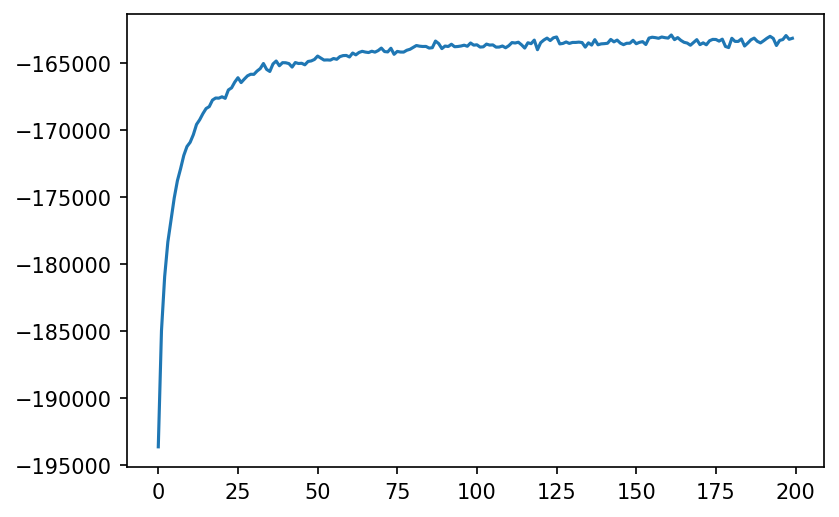

In [12]:
fig = plt.figure()
fig.set_dpi(150)
ax = fig.add_subplot(111)
ax.plot(LD.logprobs)
plt.show()

## Problem 7

Using `topterms()` to examine the topics for Reagan's addresses.
Come up with labels for each topic.
If `ntopics=20` and `n=10`, we will get the top $10$ words that represent each of the $20$ topics; for each topic, decide what these ten words jointly represent.

In [46]:
topics = LD.topterms()

labels = ["tax reform", "safety from tragedy", "family and education", "defense and world peace", 
          "senate performance", "government spending reform", "USA R&D", "the cutting edge", 
          "the best parts of America", "foreign polcy", "state of the union", "social programs", 
          "god bless America", "the job market", "crime statistics", "the American dream", 
          "we are free", "unite America", "Reagonomics", "federal budget"]


for i, lab in enumerate(labels):
    if i != 20:
        curr_str = "topic: {0}\ntop terms: {1}\nlabel: {2}\n".format(i+1, topics[i], lab)
    else:
        curr_str = "topic: {0}\ntop terms: {1}\nlabel: {2}".format(i+1, topics[i], lab)
    print(curr_str)

topic: 1
top terms: ['tax', 'reform', 'space', 'continue', "we'll", 'needed', 'develop', '--', 'plan', 'protect']
label: tax reform

topic: 2
top terms: ['.', 'past', 'years,', 'now,', 'safety.', 'tragedy', 'future.', 'woman', 'heroism', 'courage']
label: safety from tragedy

topic: 3
top terms: ['children', 'family', 'families', 'child', 'school', 'life', 'education', 'parents', 'full', 'human']
label: family and education

topic: 4
top terms: ['defense', 'soviet', 'security', 'arms', 'nuclear', 'military', 'world', 'peace', "we've", 'national']
label: defense and world peace

topic: 5
top terms: ['mr.', 'congress,', 'members', 'speaker,', 'president,', 'bipartisan', 'distinguished', 'senate', "i'm", 'tonight']
label: senate performance

topic: 6
top terms: ['tax', 'economic', 'spending', 'government', 'interest', 'billion', 'inflation', 'rates', 'federal', '--']
label: government spending reform

topic: 7
top terms: ['industry', 'research', 'program.', "we're", 'business', 'save', 's